# Capstone Project: Model Comparison (GridSearch + Cross-Validation)

**Models:** Logistic Regression (baseline) vs XGBoost (boosted trees)

**Goal:** Compare models for predicting **30-day readmission** (`readmitted_binary`) using **cross-validation** and **GridSearchCV**, then evaluate best models on a held-out test set.

> Designed to run in VS Code. Saves artifacts to `output/readmitted_binary/model_comparison_gridsearch/`.

In [3]:
# 1) Imports and Setup
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUTPUT_DIR = Path("../Output/readmitted_binary/model_comparison_gridsearch")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUTPUT_DIR.resolve())


Output dir: C:\Users\karen\Downloads\UCB-ML-AI-Capstone-Project-Predicting-30-Day-Hospital-Readmission-for-Diabetic-Patients\Output\readmitted_binary\model_comparison_gridsearch


## 2) Load Data

Expected path: `Processed Data/processed_diabetes_data.csv`.

This notebook tries:
- `../Processed Data/processed_diabetes_data.csv` (if notebook is inside `notebooks/`)
- `Processed Data/processed_diabetes_data.csv` (if notebook is in repo root)


In [4]:
# 2) Load Data
from pathlib import Path

def load_processed_data():
    candidates = [
        Path("../Processed Data/processed_diabetes_data.csv"),
        Path("Processed Data/processed_diabetes_data.csv"),
    ]
    for p in candidates:
        if p.exists():
            print(f"Loaded: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError(
        "Could not find processed_diabetes_data.csv. "
        "Expected in 'Processed Data/processed_diabetes_data.csv'."
    )

data = load_processed_data()
print("Shape:", data.shape)
data.head()


Loaded: ..\Processed Data\processed_diabetes_data.csv
Shape: (101766, 49)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,Caucasian,Female,[0-10),Unknown,6,25,1,1,Unknown,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,NO,0
1,Caucasian,Female,[10-20),Unknown,1,1,7,3,Unknown,Unknown,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,Unknown,Unknown,...,No,No,No,No,No,No,No,Yes,NO,0
3,Caucasian,Male,[30-40),Unknown,1,1,7,2,Unknown,Unknown,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,Caucasian,Male,[40-50),Unknown,1,1,7,1,Unknown,Unknown,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


## 3) Define Target and Features

We use `readmitted_binary` if present; otherwise we fall back to `readmitted`.
Target should be binary (0/1).

In [14]:
# 3) Define Target and Features (FIXED — remove leakage)

target_candidates = ["readmitted_binary", "readmitted"]
target_col = next((c for c in target_candidates if c in data.columns), None)

if target_col is None:
    raise ValueError(f"Target not found. Expected one of: {target_candidates}")

y = data[target_col].copy()

# Ensure binary numeric 0/1
if y.dtype == "object":
    y = y.astype(str).str.strip()
    mapping = {"1": 1, "0": 0, "yes": 1, "no": 0, "<30": 1, ">30": 0, "NO": 0}
    y = y.map(lambda v: mapping.get(v, v)).astype(int)

# ❗ REMOVE ALL LEAKAGE COLUMNS
leak_cols = [col for col in data.columns if "readmitted" in col.lower() and col != target_col]

X = data.drop(columns=[target_col] + leak_cols)

print("Target:", target_col)
print("Removed leakage columns:", leak_cols)
print("y distribution:\n", y.value_counts(normalize=True).round(3))
print("Feature columns:", X.shape[1])


Target: readmitted_binary
Removed leakage columns: ['readmitted']
y distribution:
 readmitted_binary
0    0.888
1    0.112
Name: proportion, dtype: float64
Feature columns: 47


## 4) Quick EDA (Checks)

Saves class balance plot to output folder.

race                        0.0
gender                      0.0
age                         0.0
weight                      0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
payer_code                  0.0
medical_specialty           0.0
dtype: float64

Numeric cols: 11
Categorical cols: 36


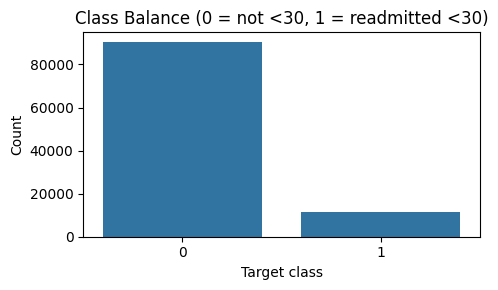

In [15]:
# 4) Quick EDA
missing_pct = (X.isna().mean().sort_values(ascending=False) * 100).round(2)
display(missing_pct.head(10))

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

plt.figure(figsize=(5,3))
sns.countplot(x=y)
plt.title("Class Balance (0 = not <30, 1 = readmitted <30)")
plt.xlabel("Target class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "class_balance.png", dpi=150)
plt.show()


## 5) Train/Test Split

Hold out 20% as the final test set.

In [16]:
# 5) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (81412, 47) Test: (20354, 47)


## 6) Preprocessing (Impute + Encode)

- Numeric: median impute + StandardScaler
- Categorical: most-frequent impute + OneHotEncoder

In [17]:
# 6) Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)


## 7) Logistic Regression + GridSearchCV

**Scoring:** ROC-AUC (good for imbalanced classification)


In [18]:
# 7) Logistic Regression Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lr = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=RANDOM_STATE)
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr)
])

lr_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

lr_grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)
print("Best LR params:", lr_grid.best_params_)
print("Best LR CV ROC-AUC:", round(lr_grid.best_score_, 4))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best LR params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best LR CV ROC-AUC: 0.6506


## 8) XGBoost + GridSearchCV

We tune a practical set of parameters.

In [19]:
# 8) XGBoost Grid Search
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])

xgb_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB CV ROC-AUC:", round(xgb_grid.best_score_, 4))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGB params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best XGB CV ROC-AUC: 0.6769


## 9) Held-out Test Evaluation + Saved Artifacts

Saves classification reports, confusion matrices, ROC curves, and best params.

In [20]:
# 9) Evaluation helpers
def save_json(obj, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def export_classification_report(y_true, y_pred, out_csv: Path):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    pd.DataFrame(report_dict).T.to_csv(out_csv, index=True)

def plot_and_save_confusion_matrix(y_true, y_pred, title, outpath: Path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def plot_and_save_roc(y_true, y_proba, title, outpath: Path):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    plt.plot([0,1], [0,1], "k--", label="Random")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()
    return auc_val

def evaluate_best_model(grid, model_name: str):
    best_est = grid.best_estimator_
    y_pred = best_est.predict(X_test)
    y_proba = best_est.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, y_proba)

    save_json(grid.best_params_, OUTPUT_DIR / f"best_params_{model_name}.json")
    export_classification_report(y_test, y_pred, OUTPUT_DIR / f"classification_report_{model_name}.csv")
    plot_and_save_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {model_name}", OUTPUT_DIR / f"confusion_matrix_{model_name}.png")
    plot_and_save_roc(y_test, y_proba, f"ROC Curve - {model_name}", OUTPUT_DIR / f"roc_{model_name}.png")

    return {"Model": model_name, "Test ROC-AUC": test_auc}

results = []
results.append(evaluate_best_model(lr_grid, "LogReg_GridSearch"))
results.append(evaluate_best_model(xgb_grid, "XGB_GridSearch"))

results_df = pd.DataFrame(results).sort_values("Test ROC-AUC", ascending=False)
results_df.to_csv(OUTPUT_DIR / "model_comparison_test_auc.csv", index=False)

results_df


,Model,Test ROC-AUC
1,XGB_GridSearch,0.685847
0,LogReg_GridSearch,0.660124


## 10) XGBoost Feature Importance (Top 15)

Extracts feature names after preprocessing (including one-hot expansion) and saves:
- `feature_importance_XGB_top15.csv`
- `feature_importance_XGB_top15.png`

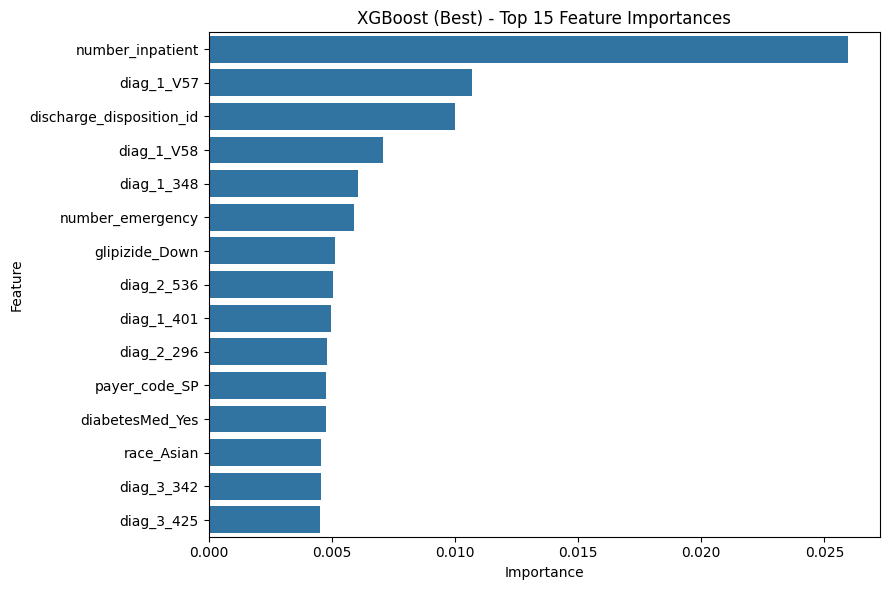

number_inpatient            0.025961
diag_1_V57                  0.010691
discharge_disposition_id    0.010019
diag_1_V58                  0.007072
diag_1_348                  0.006054
number_emergency            0.005894
glipizide_Down              0.005145
diag_2_536                  0.005038
diag_1_401                  0.004948
diag_2_296                  0.004810
payer_code_SP               0.004758
diabetesMed_Yes             0.004744
race_Asian                  0.004576
diag_3_342                  0.004557
diag_3_425                  0.004517
dtype: float32

In [21]:
# 10) Feature importance (XGB best)
best_xgb = xgb_grid.best_estimator_
pre = best_xgb.named_steps["preprocess"]

# Feature names
num_features = numeric_cols
cat_features = []
if len(categorical_cols) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = num_features + cat_features

xgb_model = best_xgb.named_steps["model"]
importances = xgb_model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)
feat_imp.to_csv(OUTPUT_DIR / "feature_importance_XGB_top15.csv", header=["importance"])

plt.figure(figsize=(9,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("XGBoost (Best) - Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "feature_importance_XGB_top15.png", dpi=150)
plt.show()

feat_imp


## 11) Final Summary for README

This cell prints CV AUC and test AUC. Use the saved artifacts in your README results section.

In [22]:
# 11) Summary for README
print("=== CV ROC-AUC (5-fold) ===")
print("LogReg best CV ROC-AUC:", round(lr_grid.best_score_, 4))
print("XGB   best CV ROC-AUC:", round(xgb_grid.best_score_, 4))

print("\n=== Test ROC-AUC (held-out) ===")
display(results_df)

print("\nArtifacts saved to:", OUTPUT_DIR)


=== CV ROC-AUC (5-fold) ===
LogReg best CV ROC-AUC: 0.6506
XGB   best CV ROC-AUC: 0.6769

=== Test ROC-AUC (held-out) ===


,Model,Test ROC-AUC
1,XGB_GridSearch,0.685847
0,LogReg_GridSearch,0.660124



Artifacts saved to: ..\Output\readmitted_binary\model_comparison_gridsearch
